In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import normalize
from scipy import interp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 


name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list1 = []
list2 = []
list = []
for d in data:
    list1.append(d[0])  
    list2.append(d[1])  
    list.append(d)  
list1 = np.asarray(list1)    
list2 = np.asarray(list2)    

In [3]:
print (list)
print ('-------------------------------------------------------------------------------------------------')
listq = np.unique(list1)
print (listq)
list3 = []
for d in range(len(listq)):
    l = np.where(list1 == listq[d])
    list3.append(l[0]) 

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4', 4), ('G

In [4]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 15
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st],
         list3[10][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((11*(st-1)))
print (listh)
print (list2[listh])

[array([  6,   7,  29,  45,  62,  72,  81, 104, 109, 110, 116, 118, 125,
       134, 171, 179, 192, 195, 196, 218]), array([  2,  13,  26,  34,  41,  50,  66,  76,  84, 103, 114, 115, 129,
       137, 163, 166, 174, 181, 188, 214]), array([  5,  20,  24,  38,  53,  58,  64,  73,  87, 102, 111, 126, 140,
       151, 157, 164, 177, 190, 197, 210]), array([ 16,  17,  27,  31,  44,  49,  60,  61,  97,  98, 121, 136, 153,
       154, 155, 167, 187, 200, 201, 219]), array([ 14,  19,  25,  30,  46,  52,  59,  63,  94, 101, 108, 112, 117,
       133, 156, 170, 184, 189, 198, 203]), array([  3,  23,  35,  40,  51,  54,  68,  75,  85,  90, 122, 128, 138,
       175, 180, 204, 206, 207, 209, 213]), array([  1,  11,  33,  42,  67,  71,  77,  83,  91,  96, 100, 120, 130,
       143, 148, 158, 162, 173, 205, 215]), array([  9,  10,  22,  55,  56,  69,  89, 106, 107, 123, 142, 144, 145,
       146, 152, 160, 161, 193, 194, 212]), array([  4,   8,  21,  36,  39,  57,  70,  74,  86,  88, 124, 127, 139,

In [5]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 2
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 77000


In [6]:
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

/home/lolo/Desktop/dnnComm/vde/vde/utils.py:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight.data)
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
# for some reasons autocorr_loss does behave properly!
mdl.fit(trajs)

Epoch: 0


/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:271: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  print('Batch %d, loss = %.4f' % (t + 1, loss.data[0]))
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:275: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  'autocorr_loss = %.4f' % (rec_loss.data[0],
/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/vde-0.1a0-py3.6.egg/vde/vde.py:276: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  autocorr_loss.data[0]))


Batch 100, loss = 1.0334
rec_loss = 0.0553, autocorr_loss = 0.9782
Batch 200, loss = 1.0450
rec_loss = 0.0458, autocorr_loss = 0.9992
Batch 300, loss = 0.8517
rec_loss = 0.0308, autocorr_loss = 0.8209
Batch 400, loss = 0.8132
rec_loss = 0.0257, autocorr_loss = 0.7876
Batch 500, loss = 0.8786
rec_loss = 0.0204, autocorr_loss = 0.8582
Batch 600, loss = 0.7496
rec_loss = 0.0227, autocorr_loss = 0.7270
Batch 700, loss = 0.8227
rec_loss = 0.0187, autocorr_loss = 0.8040
Batch 800, loss = 0.7262
rec_loss = 0.0211, autocorr_loss = 0.7051
Batch 900, loss = 0.8989
rec_loss = 0.0172, autocorr_loss = 0.8817
Batch 1000, loss = 0.7244
rec_loss = 0.0148, autocorr_loss = 0.7096
Batch 1100, loss = 0.8943
rec_loss = 0.0150, autocorr_loss = 0.8793
Batch 1200, loss = 0.7163
rec_loss = 0.0171, autocorr_loss = 0.6991
Batch 1300, loss = 0.8002
rec_loss = 0.0164, autocorr_loss = 0.7838
Batch 1400, loss = 0.8830
rec_loss = 0.0167, autocorr_loss = 0.8663
Batch 1500, loss = 0.6258
rec_loss = 0.0142, autocorr_los

In [8]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

500


/home/lolo/miniconda3/envs/dnnComm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


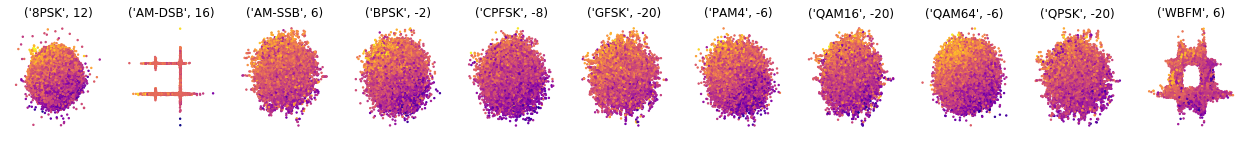

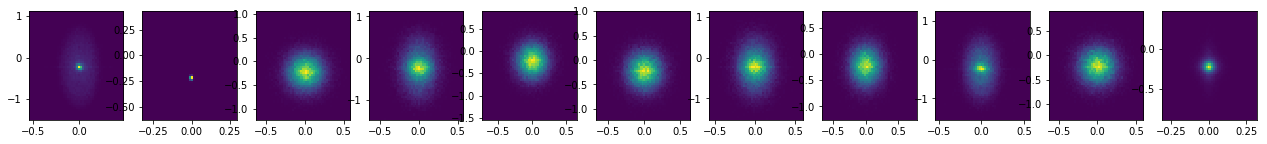

In [9]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl, cmap='plasma_r', l=c*(st-1), ax=ax1)
        ax1.set_title(list[listh[c*(st-1)]]); clean_up(ax1)
        c += 1
plt.savefig('result11.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl, cmap='plasma_r', l=c*(st-1), ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result12.png')
#plt.close(fig)

In [10]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')    
th = 18
listt = [list3[0][th], list3[1][th], list3[2][th], list3[3][th], list3[4][th],
         list3[5][th], list3[6][th], list3[7][th], list3[8][th], list3[9][th],
         list3[10][th]]
listt = np.asarray(listt, dtype=np.int)
print (listt)
print (list2[listt])

[array([  6,   7,  29,  45,  62,  72,  81, 104, 109, 110, 116, 118, 125,
       134, 171, 179, 192, 195, 196, 218]), array([  2,  13,  26,  34,  41,  50,  66,  76,  84, 103, 114, 115, 129,
       137, 163, 166, 174, 181, 188, 214]), array([  5,  20,  24,  38,  53,  58,  64,  73,  87, 102, 111, 126, 140,
       151, 157, 164, 177, 190, 197, 210]), array([ 16,  17,  27,  31,  44,  49,  60,  61,  97,  98, 121, 136, 153,
       154, 155, 167, 187, 200, 201, 219]), array([ 14,  19,  25,  30,  46,  52,  59,  63,  94, 101, 108, 112, 117,
       133, 156, 170, 184, 189, 198, 203]), array([  3,  23,  35,  40,  51,  54,  68,  75,  85,  90, 122, 128, 138,
       175, 180, 204, 206, 207, 209, 213]), array([  1,  11,  33,  42,  67,  71,  77,  83,  91,  96, 100, 120, 130,
       143, 148, 158, 162, 173, 205, 215]), array([  9,  10,  22,  55,  56,  69,  89, 106, 107, 123, 142, 144, 145,
       146, 152, 160, 161, 193, 194, 212]), array([  4,   8,  21,  36,  39,  57,  70,  74,  86,  88, 124, 127, 139,

In [11]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 1
for l in range(len(listt)):
    d = data[list[listt[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 11000


In [12]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


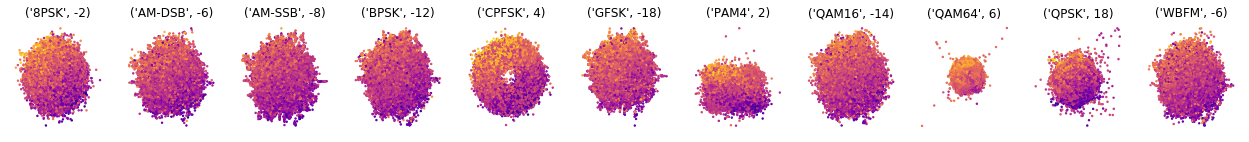

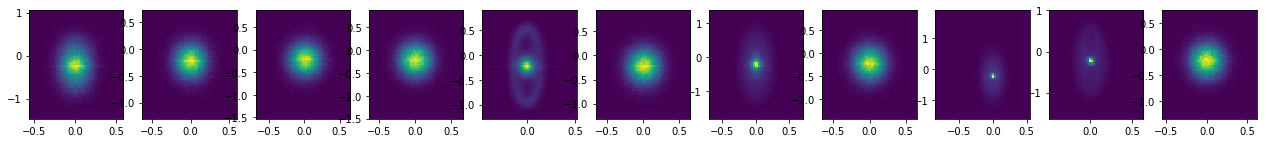

In [13]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result21.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result22.png')
#plt.close(fig)

In [15]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')  
st = 15
listh = [list3[0][1:st], list3[1][1:st], list3[2][1:st], list3[3][1:st], list3[4][1:st],
         list3[5][1:st], list3[6][1:st], list3[7][1:st], list3[8][1:st], list3[9][1:st]]
listh = np.asarray(listh, dtype=np.int).reshape((10*(st-1)))
print (listh)
print (list2[listh])

[array([  6,   7,  29,  45,  62,  72,  81, 104, 109, 110, 116, 118, 125,
       134, 171, 179, 192, 195, 196, 218]), array([  2,  13,  26,  34,  41,  50,  66,  76,  84, 103, 114, 115, 129,
       137, 163, 166, 174, 181, 188, 214]), array([  5,  20,  24,  38,  53,  58,  64,  73,  87, 102, 111, 126, 140,
       151, 157, 164, 177, 190, 197, 210]), array([ 16,  17,  27,  31,  44,  49,  60,  61,  97,  98, 121, 136, 153,
       154, 155, 167, 187, 200, 201, 219]), array([ 14,  19,  25,  30,  46,  52,  59,  63,  94, 101, 108, 112, 117,
       133, 156, 170, 184, 189, 198, 203]), array([  3,  23,  35,  40,  51,  54,  68,  75,  85,  90, 122, 128, 138,
       175, 180, 204, 206, 207, 209, 213]), array([  1,  11,  33,  42,  67,  71,  77,  83,  91,  96, 100, 120, 130,
       143, 148, 158, 162, 173, 205, 215]), array([  9,  10,  22,  55,  56,  69,  89, 106, 107, 123, 142, 144, 145,
       146, 152, 160, 161, 193, 194, 212]), array([  4,   8,  21,  36,  39,  57,  70,  74,  86,  88, 124, 127, 139,

In [16]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 2
for l in range(len(listh)):
    d = data[list[listh[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 70000


In [17]:
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [18]:
# for some reasons autocorr_loss does behave properly!
mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 1.0181
rec_loss = 0.0749, autocorr_loss = 0.9432
Batch 200, loss = 0.8049
rec_loss = 0.0463, autocorr_loss = 0.7586
Batch 300, loss = 0.8626
rec_loss = 0.0383, autocorr_loss = 0.8244
Batch 400, loss = 0.8014
rec_loss = 0.0282, autocorr_loss = 0.7732
Batch 500, loss = 0.9037
rec_loss = 0.0269, autocorr_loss = 0.8768
Batch 600, loss = 0.9080
rec_loss = 0.0217, autocorr_loss = 0.8863
Batch 700, loss = 0.7976
rec_loss = 0.0253, autocorr_loss = 0.7723
Batch 800, loss = 0.7512
rec_loss = 0.0196, autocorr_loss = 0.7316
Batch 900, loss = 0.6986
rec_loss = 0.0183, autocorr_loss = 0.6803
Batch 1000, loss = 0.7487
rec_loss = 0.0152, autocorr_loss = 0.7335
Batch 1100, loss = 0.7009
rec_loss = 0.0170, autocorr_loss = 0.6839
Batch 1200, loss = 0.9104
rec_loss = 0.0163, autocorr_loss = 0.8941
Batch 1300, loss = 0.7053
rec_loss = 0.0154, autocorr_loss = 0.6898
Batch 1400, loss = 0.7129
rec_loss = 0.0159, autocorr_loss = 0.6971
Batch 1500, loss = 0.6830
rec_loss = 0.0146, aut

In [19]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

500


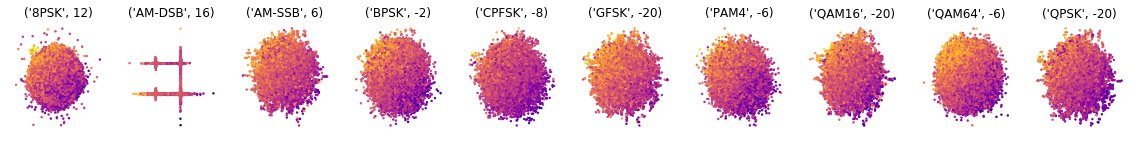

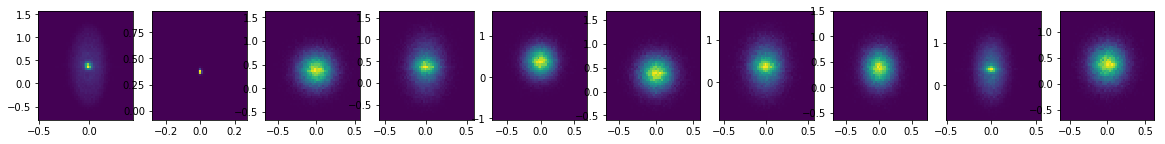

In [21]:
fig = plt.figure(figsize=(2*10, 1*2))
c = 0
for j in range(10):
        ax1 = fig.add_subplot(1, 10, j+1)
        scatter(mdl, cmap='plasma_r', l=c*(st-1), ax=ax1)
        ax1.set_title(list[listh[c*(st-1)]]); clean_up(ax1)
        c += 1
plt.savefig('result31.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*10, 1*2))
c = 0
for j in range(10):
        ax2 = fig.add_subplot(1, 10, j+1)
        hist(mdl, cmap='plasma_r', l=c*(st-1), ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result32.png')
#plt.close(fig)

In [22]:
print (list3)
print ('-------------------------------------------------------------------------------------------------')    
th = 18
listt = [list3[0][th], list3[1][th], list3[2][th], list3[3][th], list3[4][th],
         list3[5][th], list3[6][th], list3[7][th], list3[8][th], list3[9][th],
         list3[10][th]]
listt = np.asarray(listt, dtype=np.int)
print (listt)
print (list2[listt])

[array([  6,   7,  29,  45,  62,  72,  81, 104, 109, 110, 116, 118, 125,
       134, 171, 179, 192, 195, 196, 218]), array([  2,  13,  26,  34,  41,  50,  66,  76,  84, 103, 114, 115, 129,
       137, 163, 166, 174, 181, 188, 214]), array([  5,  20,  24,  38,  53,  58,  64,  73,  87, 102, 111, 126, 140,
       151, 157, 164, 177, 190, 197, 210]), array([ 16,  17,  27,  31,  44,  49,  60,  61,  97,  98, 121, 136, 153,
       154, 155, 167, 187, 200, 201, 219]), array([ 14,  19,  25,  30,  46,  52,  59,  63,  94, 101, 108, 112, 117,
       133, 156, 170, 184, 189, 198, 203]), array([  3,  23,  35,  40,  51,  54,  68,  75,  85,  90, 122, 128, 138,
       175, 180, 204, 206, 207, 209, 213]), array([  1,  11,  33,  42,  67,  71,  77,  83,  91,  96, 100, 120, 130,
       143, 148, 158, 162, 173, 205, 215]), array([  9,  10,  22,  55,  56,  69,  89, 106, 107, 123, 142, 144, 145,
       146, 152, 160, 161, 193, 194, 212]), array([  4,   8,  21,  36,  39,  57,  70,  74,  86,  88, 124, 127, 139,

In [23]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 16
trajs = []
stride = 1
for l in range(len(listt)):
    d = data[list[listt[l]]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd, axis=1, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 32)
#data 11000


In [24]:
delta = np.int(data[list[0]].shape[0]/stride)
print (delta)
def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

1000


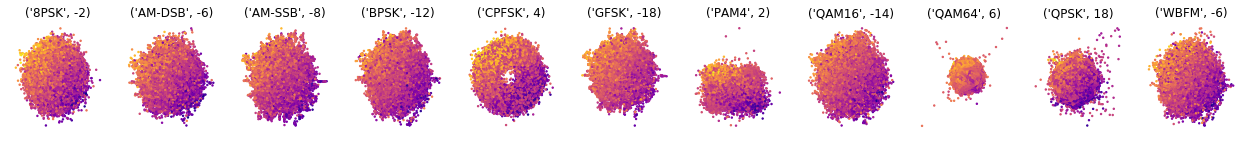

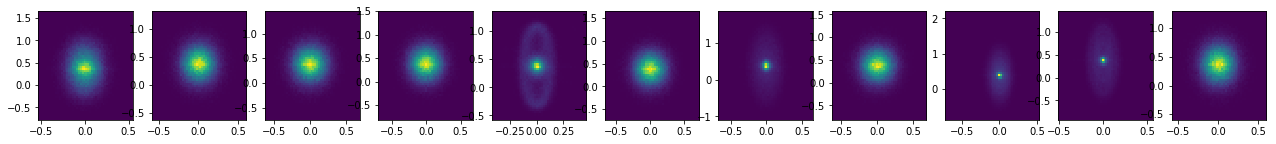

In [25]:
fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax1 = fig.add_subplot(1, 11, j+1)
        scatter(mdl, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[listt[c]]); clean_up(ax1)
        c += 1
plt.savefig('result41.png')
#plt.close(fig)

fig = plt.figure(figsize=(2*11, 1*2))
c = 0
for j in range(11):
        ax2 = fig.add_subplot(1, 11, j+1)
        hist(mdl, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
plt.savefig('result42.png')
#plt.close(fig)

In [26]:
import zmq
import array

socket_str = 'tcp://127.0.0.1:5557'


def zmq_consumer(T):
    context = zmq.Context()
    results_receiver = context.socket(zmq.PULL)
    results_receiver.connect(socket_str)
    raw_data = results_receiver.recv()
    float_list = array.array('f', raw_data)
    t = 0
    data = []
    for signal_val in float_list:
        data.append(np.float(signal_val))
        t += 1
        if t >= T: 
            break;
    DATA = np.zeros((T), dtype=np.float)
    DATA[0:len(data)] = data
    return DATA                              

Text(0.5,1,'SDR data')

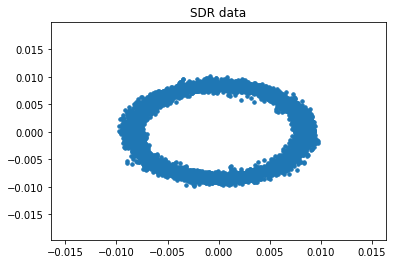

In [32]:
L = 50
T = 128*2*L
data_ = zmq_consumer(T)
plt.figure()
plt.scatter(data_[0:T:2], data_[1:T:2], s=12)
plt.title('SDR data')

In [33]:
lag_time = 16
trajs_test = []

for i in range(np.int(T/(128*2))):
    dd = np.zeros((128, 2))
    dd[:, 0] = data_[i*2*128:(i+1)*2*128:2]
    dd[:, 1] = data_[i*2*128+1:(i+1)*2*128:2]
    dd = normalize(dd, axis=0, norm='l2')
    Dt = dd.shape
    dddd = dd
    for t in range(1, lag_time):
        ddd = np.zeros(Dt)
        ddd[:-t] = dd[:-t] - dd[t:]
        dddd = np.append(dddd, ddd, axis=1)
    trajs_test.append(dddd)
print (len(trajs_test), trajs_test[0].shape)    

50 (128, 32)


In [34]:
def scatter(decomposition, cmap='plasma', stride=1, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs_test[:])[::stride, 0:2].T, c=cmap(w),s=12 )

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs_test[:]))[::stride].ravel()
    ax.hist2d(np.gradient(w, axis=0), w, bins=50)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

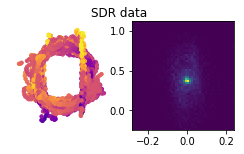

In [35]:
fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
scatter(mdl, cmap='plasma_r', ax=ax1)
clean_up(ax1)
hist(mdl, cmap='plasma_r', ax=ax2)
fig.suptitle('SDR data')
plt.savefig('result.png')

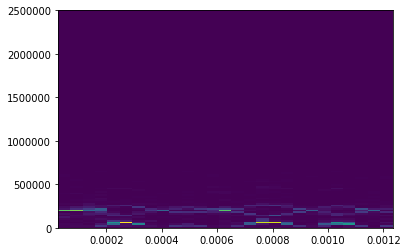

In [44]:
import scipy.signal as sc
w = np.concatenate(mdl.transform(trajs_test[:]))[::stride].ravel()
fs = 5e6
f, t, Sxx = sc.spectrogram(w, fs)
plt.pcolormesh(t, f, Sxx)
plt.show()